### $\color{magenta}{\text{DISAMBIGUATION - TEST $2$ }} $

#### Here, we focus on 'known' atmosphere dataset (pole), and we 

#### want to test our minimum energy disambiguation method. This is

#### a very complex case, because of polar geometry.

In [1]:
import numpy as np
import time
from matplotlib.transforms import Affine2D
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import astropy.io.fits as fits
from scipy.ndimage import median_filter
import re

#### $\color{magenta}{\text{We proceed to test our disambiguation routine on POLAR data.}}$

In [2]:
pole = fits.open('pole_LOS_65.fits')[0].data[:,15,:128,:128]

B, inc, az = pole[4], np.radians(pole[6]), np.radians(pole[7]) # [0, 360] degrees

Bx = B * np.sin(inc) * np.cos(az) # not only positive anymore!
By = B * np.sin(inc) * np.sin(az)
Bz = B * np.cos(inc)
Btr = np.sqrt(Bx**2 + By**2)

In [3]:
from MEM_pole import MinimumEnergyDisambiguator

start = time.time()
disambig = MinimumEnergyDisambiguator(Bx, By, Bz, az=az, dx=1, dy=1, lambda_factor=1)

disambig.simulated_annealing(
    neq=150, # number of reconfiguration attempts per temperature step (100-500)
    tfac0=0.1, # initial temperature scaling factor (0.05-0.2)
    tfactr=0.96, # cooling rate (0.85-0.98)
    tol_conv=1e-4, # convergence tolerance for relative energy change (1e-5-1e-4)
    nconv_min=50, # number of consecutive iterations with negligible change required for convergence (10-100)
    tstop_par=1e-4, # stopping temperature as a fraction of the initial temperature (1e-3-1e-5)
    max_iter=500, # maximum number of iterations (100-1000)
    Btr_threshold=150 # transverse magnetic field component threshold (100-200: strong)
)
disambig.acute_angle_weak(Btr_threshold=150, # transverse magnetic field component threshold (weak)
                          max_iterations=15, # number of iterations (5-20)
                          conv_threshold=1e-3) # convergence threshold 
disambig.save_disambiguation_results()

end = time.time()
print('Time it took to disambiguate polar FOV of size 128²: {:.2f} s'.format(end - start))

Disambiguation [strong-masked fields] - simulated_annealing:  21%|███████████████████                                                                       | 106/500 [00:21<01:19,  4.97it/s]


Acute-angle method [weak fields] converged after 9 iterations
Minimum energy disambiguation is done and results are saved!
Time it took to disambiguate polar FOV of size 128²: 42.06 s


In [4]:
Bx_mem = fits.open('MEM_disambiguation_results.fits')[0].data 
By_mem = fits.open('MEM_disambiguation_results.fits')[1].data
az_mem = fits.open('MEM_disambiguation_results.fits')[2].data
Jz_mem = fits.open('MEM_disambiguation_results.fits')[3].data

Btr_mem = np.sqrt(Bx_mem**2 + By_mem**2)

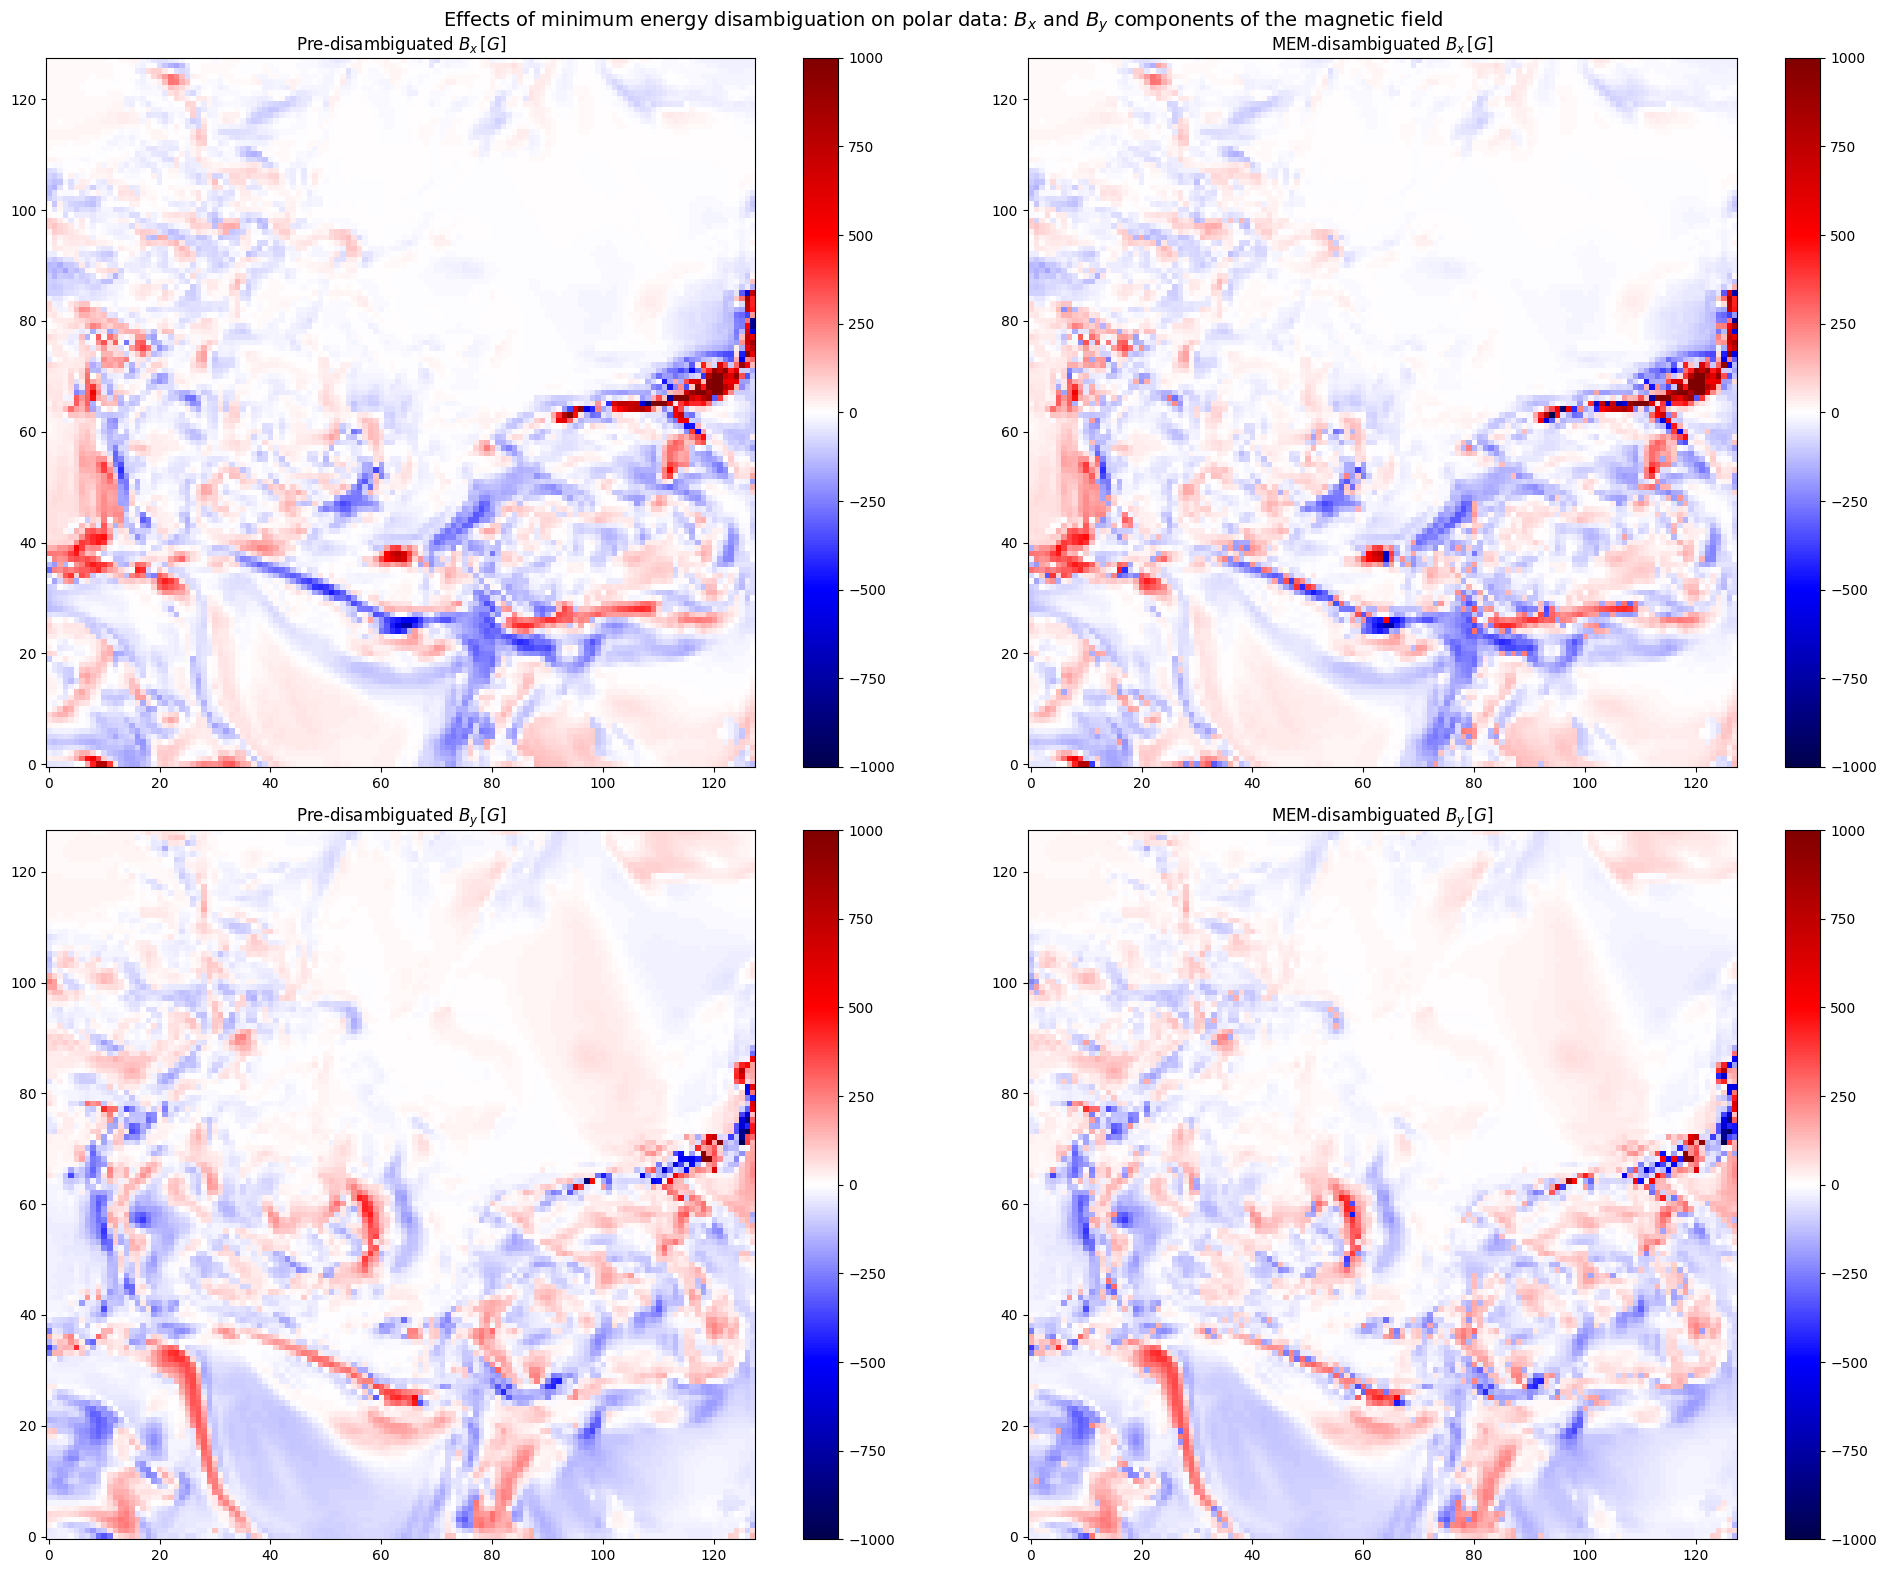

In [5]:
plots = [Bx, Bx_mem, By, By_mem]
titles = [r'Pre-disambiguated $B_x\,[G]$',  
          r'MEM-disambiguated $B_x\,[G]$', 
          r'Pre-disambiguated $B_y\,[G]$',
          r'MEM-disambiguated $B_y\,[G]$']

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        ax = axes[i, j]
        if i == 0: 
            vmin, vmax = -1000, 1000
        else:
            vmin, vmax = -1000, 1000
        im = ax.imshow(plots[idx], origin='lower', cmap='seismic', vmin=vmin, vmax=vmax)
        ax.set_title(titles[idx])
        fig.colorbar(im, ax=ax)

plt.suptitle(r'Effects of minimum energy disambiguation on polar data: $B_x$ and $B_y$ components of the magnetic field',
            fontsize=14)
plt.tight_layout()
plt.show()

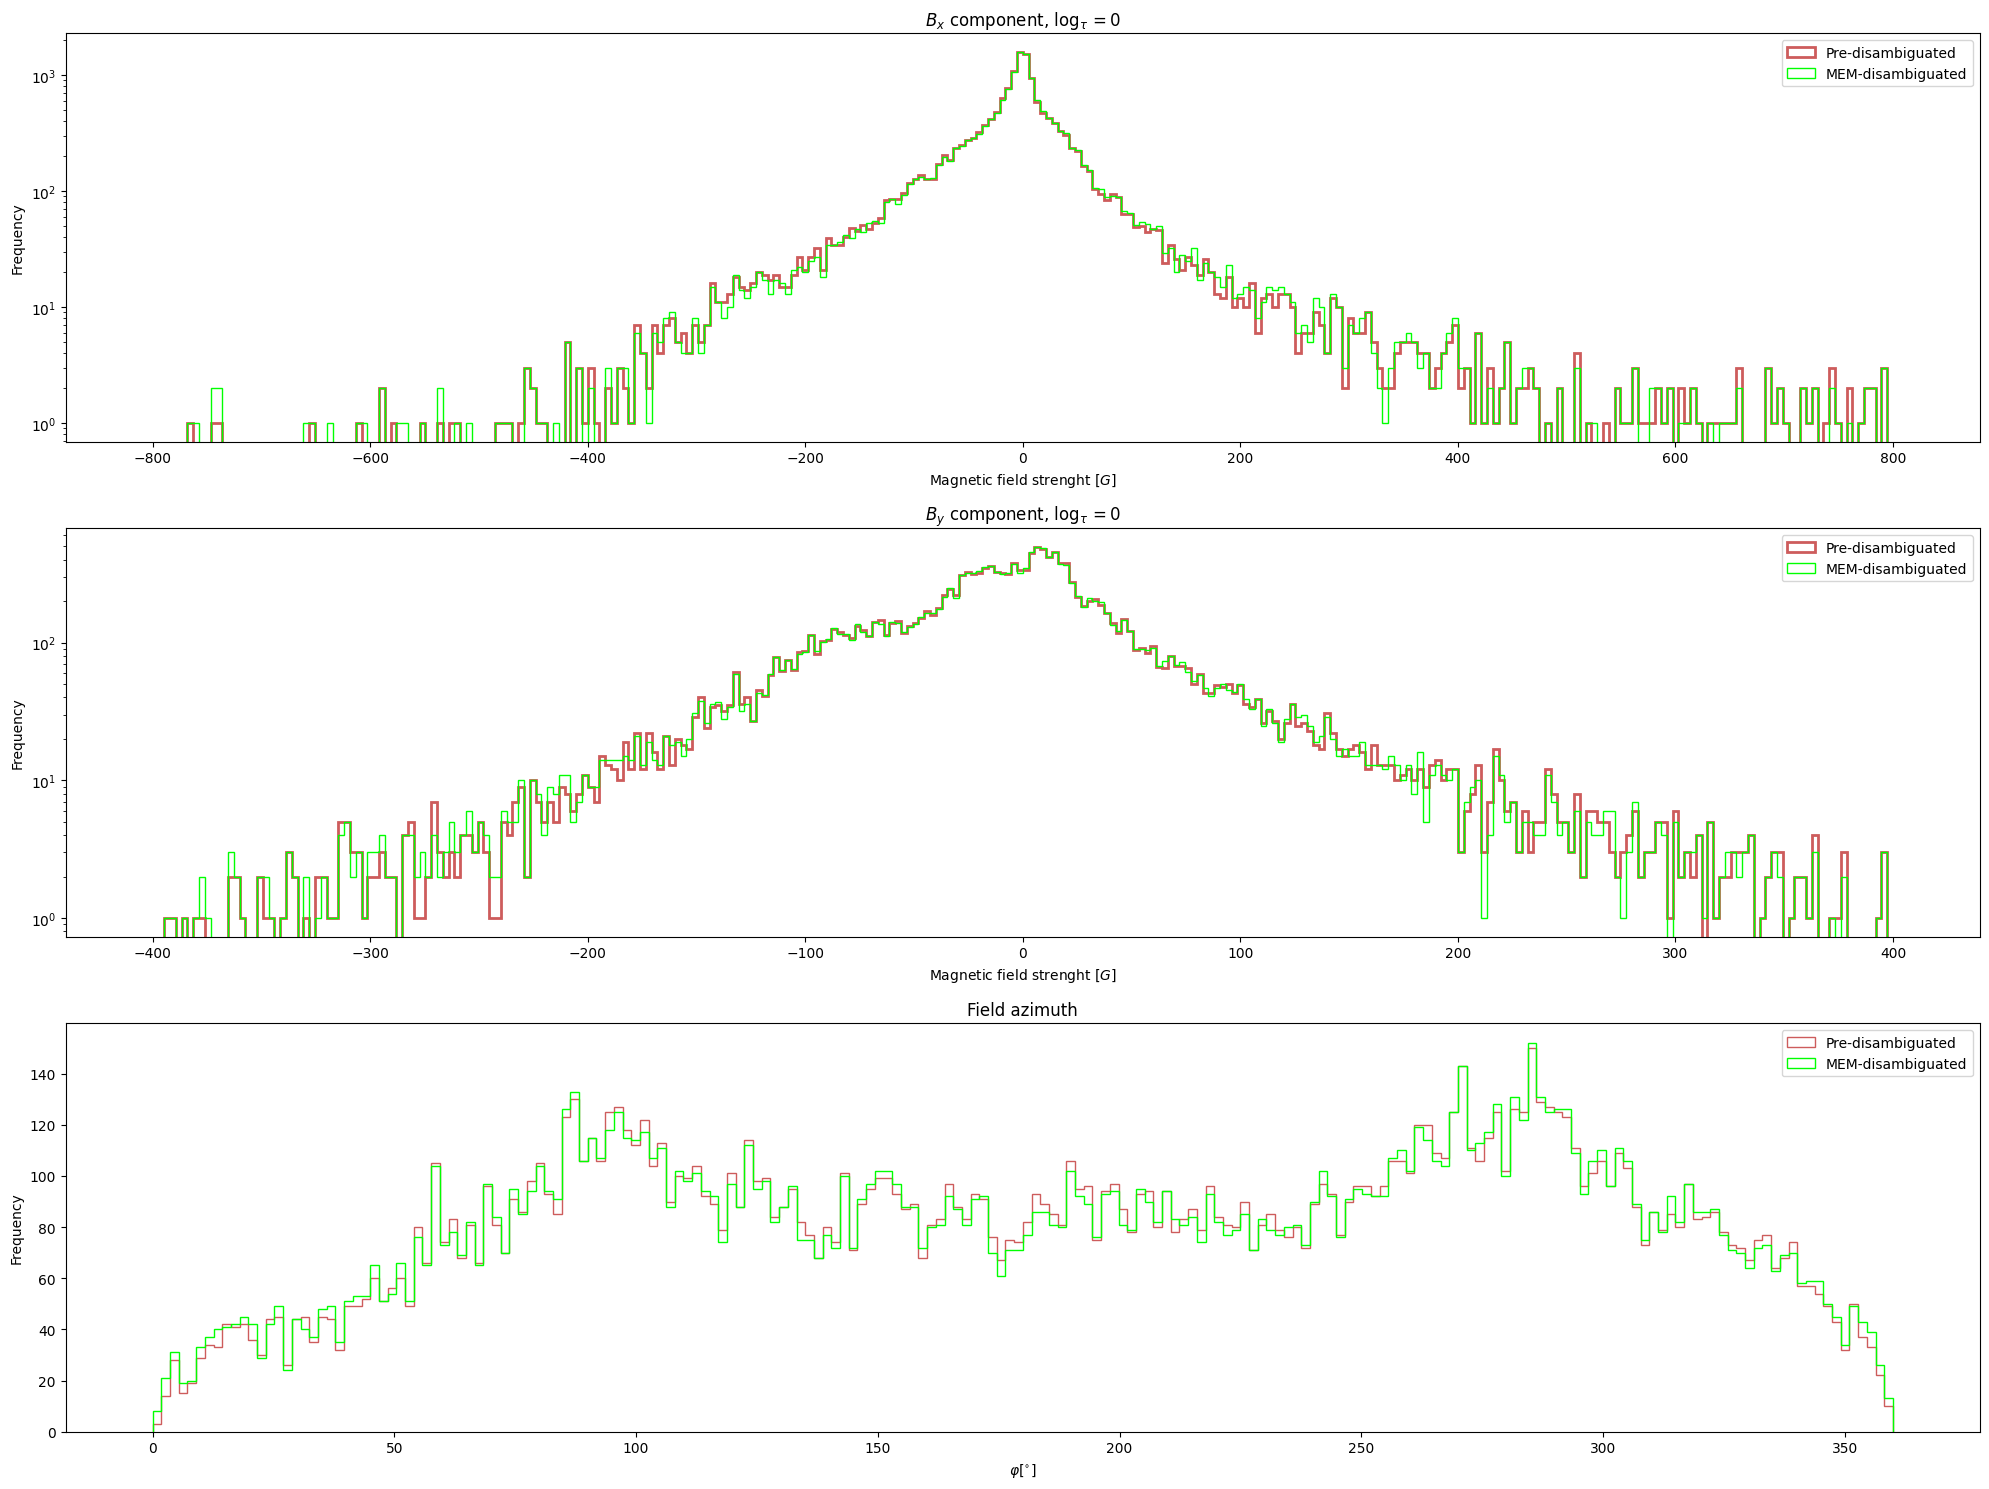

In [11]:
plt.figure(figsize=(20,15))

plt.subplot(311)
plt.hist(Bx.ravel(), bins=300, color='indianred', label=r'Pre-disambiguated', histtype='step', range=(-800,800),
        linewidth=2)
plt.hist(Bx_mem.ravel(), bins=300, color='lime', label=r'MEM-disambiguated', histtype='step', range=(-800,800))
plt.title(r'$B_x$ component, $\log_{\tau}=0$')
plt.xlabel(r'Magnetic field strenght $[G]$')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()

plt.subplot(312)
plt.hist(By.ravel(), bins=300, color='indianred', label=r'Pre-disambiguated', histtype='step', range=(-400,400),
        linewidth=2)
plt.hist(By_mem.ravel(), bins=300, color='lime', label=r'MEM-disambiguated', histtype='step', range=(-400,400))
plt.title(r'$B_y$ component, $\log_{\tau}=0$')
plt.xlabel(r'Magnetic field strenght $[G]$')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()

plt.subplot(313)
plt.hist(np.degrees(az).ravel(), bins=200, histtype='step', color='indianred', label=r'Pre-disambiguated',
         range=(0,360))
plt.hist(az_mem.ravel(), bins=200, histtype='step', color='lime', label=r'MEM-disambiguated',
         range=(0,360))
plt.title(r'Field azimuth')
plt.xlabel(r'$\varphi[^{\circ}]$')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()